# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.298744,True,4.734315
1,1.897935,False,-0.248138
2,0.865948,False,0.709972
3,0.002909,True,2.744047
4,2.002586,True,6.070389
...,...,...,...
995,0.835879,False,0.051443
996,1.544201,True,4.774908
997,-0.063051,False,-0.639709
998,0.860892,True,5.796355


<AxesSubplot:xlabel='v0'>

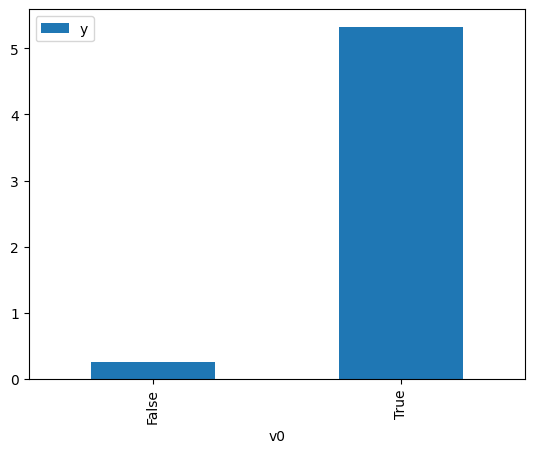

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

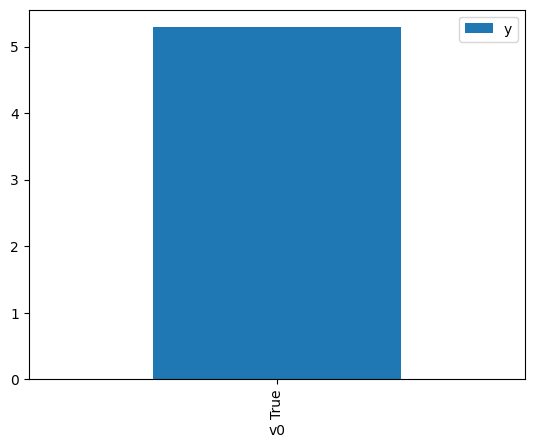

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.639095,False,-1.339608,0.315263,3.171958
1,0.497256,False,-0.780597,0.460130,2.173301
2,1.199772,False,1.283749,0.368491,2.713772
3,1.023798,False,-1.116229,0.390838,2.558606
4,0.816575,False,0.345647,0.417746,2.393800
...,...,...,...,...,...
995,0.303222,False,-0.379699,0.486209,2.056727
996,1.920872,False,0.064591,0.283413,3.528422
997,0.360403,False,-0.681723,0.478510,2.089822
998,0.699636,False,0.149905,0.433161,2.308612


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.244843,True,4.039423,0.637147,1.569496
1,0.618073,True,6.589035,0.556009,1.798533
2,-0.791350,True,6.869509,0.369319,2.707688
3,1.316310,True,4.606458,0.646010,1.547963
4,1.232205,True,7.056832,0.635570,1.573390
...,...,...,...,...,...
995,2.786407,True,7.674133,0.801292,1.247985
996,0.992320,True,5.663483,0.605113,1.652584
997,-0.448801,True,4.482842,0.413286,2.419634
998,1.500618,True,8.282816,0.668398,1.496115


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.944
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              8346.
Date:                Thu, 01 Sep 2022   Prob (F-statistic):                        0.00
Time:                        17:48:48   Log-Likelihood:                         -1417.5
No. Observations:                1000   AIC:                                      2839.
Df Residuals:                     998   BIC:                                      2849.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4791      0.032     15.113      0.000       0.417       0.541
x2             4.9968      0.051     98.221      0.000       4.897       5.097
==============================================================================
Omnibus:                        3.371   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.185   Jarque-Bera (JB):                3.430
Skew:                           0.083   Prob(JB):                        0.180
Kurtosis:                       3.234   Cond. No.                         2.23
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""